In [192]:
import pandas as pd #importing the Pandas Library as 'pd'
import numpy as np

#Imports spatial libraries
from keplergl import KeplerGl #importing KeplerGl
import geopandas as gpd #importing geopandas as 'gpd'
from shapely.geometry import Point
from shapely.geometry import box
import shapely.wkt
from geopy.geocoders import Nominatim # Imports the geopy for the geocoding
import geojson
from geojson import Point, Feature, FeatureCollection, dump
from geojson_rewind import rewind
import json



import xml.etree.ElementTree as ET
import requests
import matplotlib.pyplot as plt


from time import time

# Introduction
This notebook analyses which parts of the city that have lower income levels are not within 10 minutes of affordable food initative provision.
It is work in progress and should not be quoted. It requires the other notebook in the container to be run first.

# Takes the food outlet locations, calculate 10 minute isochrone and convert to geojson

In [193]:
## Reads in the Liverpool boundary file
filename='Data/Out/Liverpool_boundary.geojson'
file = open(filename)
Liverpool_boundary = gpd.read_file(file)

In [194]:
# Read in the affordable food initatives
filename = "Data/Out/Affordable_food_iniatives.geojson"

file = open(filename)
Affordable_food_outlets = gpd.read_file(file)

In [195]:
# Read in Foodbanks
filename = "Data/Out/Foodbanks.geojson"

file = open(filename)
Food_banks = gpd.read_file(file)

In [198]:
filename = "Data/Out/Affordable_food_iniatives.geojson"

file = open(filename)
Affordable_food_outlets = gpd.read_file(file)

In [199]:
# Characteristics for API calls to calculate 10 minute walking time

urlBase = 'https://api.mapbox.com/isochrone/v1/mapbox/'
profile = 'walking/'
minutes = 10
mapboxglaccessToken = 'pk.eyJ1Ijoiam9obmFyZGF2aWVzIiwiYSI6ImNpeHRmZjhlYjAwMmUycW9qbHRvem0xa3gifQ.oQ9cnn8b5HATalxv9rppYg'


# Function to make calls to the mapbox isochrone apis
def isochrone_api(x):
   api_call=urlBase+profile +str(x['lon'])+','+str(x['lat'])+'?contours_minutes='+str(minutes)+'&polygons=true&access_token='+mapboxglaccessToken
   try:
    walk_dist=requests.get(api_call)
    walk_iso= walk_dist.json()['features'][0]
   except:
    walk_iso="call_failed"
   return walk_iso

In [200]:
# Call the isochrone API for each of the food output locations
Affordable_food_outlets['walking_dist']=Affordable_food_outlets.apply(isochrone_api,axis=1)

In [203]:
Food_banks['walking_dist']=Food_banks.apply(isochrone_api,axis=1)

In [209]:
# Take the outputs and turn into json
travel_distances = FeatureCollection(Affordable_food_outlets['walking_dist'].values.tolist()+Food_banks['walking_dist'].values.tolist())

In [210]:
# Ensures geojson follows the right handed rule
travel_distances= rewind(travel_distances)

In [211]:
# Convert to geopandas data frame
travel_distances = gpd.GeoDataFrame.from_features(travel_distances["features"])

In [212]:
# Set projection
travel_distances= travel_distances.set_crs("EPSG:4326")

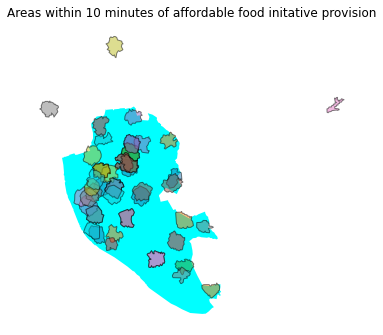

In [213]:
# Check it plots
ax =  Liverpool_boundary.plot(color='cyan', figsize=(6,13))
ax.axis('off') # Turns off the axis
plt.title("Areas within 10 minutes of affordable food initative provision")
travel_distances.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax);

In [214]:
# Export
with open('Data/Out/Isochrone.geojson', 'w') as f:
   dump(travel_distances, f)

# Identify areas with higher levels of deprivation which have lower levels of access

In [215]:
filename="Data/Out/Liverpool_lsoa.geojson"
    
file = open(filename)
Lsoa_multdep = gpd.read_file(file)

<AxesSubplot:>

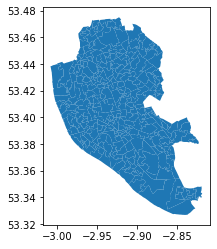

In [216]:
Lsoa_multdep.plot()

In [217]:
# List the variables
list(Lsoa_multdep)

['LSOA11CD',
 'LSOA11NM',
 'LSOA code (2011)',
 'LSOA name (2011)_x',
 'Local Authority District code (2019)_x',
 'Local Authority District name (2019)_x',
 'Total population: mid 2015 (excluding prisoners)',
 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)',
 'Population aged 16-59: mid 2015 (excluding prisoners)',
 'Older population aged 60 and over: mid 2015 (excluding prisoners)',
 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)',
 'LSOA name (2011)_y',
 'Local Authority District code (2019)_y',
 'Local Authority District name (2019)_y',
 'Income Domain numerator',
 'Income Deprivation Affecting Children Index (IDACI) numerator',
 'Income Deprivation Affecting Older People Index (IDAOPI) numerator',
 'Employment Domain numerator',
 'Staying on in education post 16 indicator',
 'Entry to higher education indicator',
 'Adult skills and English language proficiency indicator',
 'Years of potential life lost indicator',
 

In [218]:
# Select the areas in the city in the lowest income quintile
Lower_income=Lsoa_multdep[Lsoa_multdep['Income Domain numerator_rank']==5]

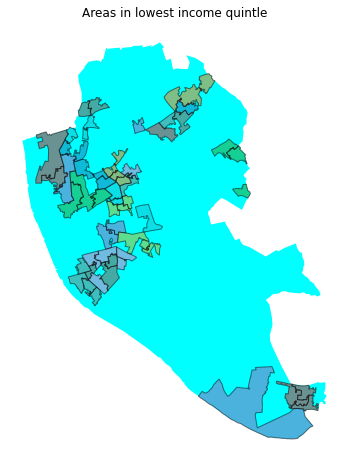

In [219]:
ax = Liverpool_boundary.plot(color='cyan', figsize=(6,13))
ax.axis('off') # Turns off the axis
plt.title("Areas in lowest income quintle")
Lower_income.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax);

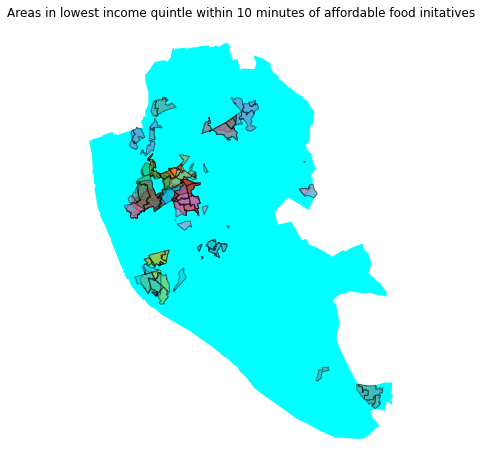

In [220]:
#Lower income levels within 10 minutes of affordable food initative provision
lower_income_withaccess = gpd.overlay(Lower_income, travel_distances, how='intersection')
ax = Liverpool_boundary.plot(color='cyan', figsize=(6,13))
ax.axis('off') # Turns off the axis
plt.title("Areas in lowest income quintle within 10 minutes of affordable food initatives")
lower_income_withaccess.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax);

Text(0.5, 1.0, 'Areas in lowest income quintiles not within 10 minutes of affordable food initative provision')

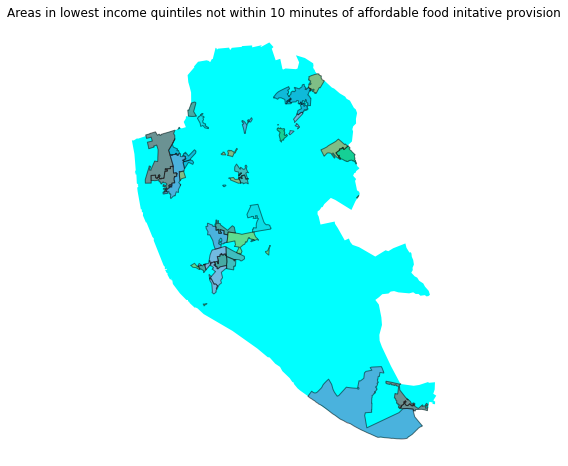

In [221]:
#Lower income levels not within 10 minutes of affordable food initative provision

lower_income_withoutaccess = gpd.overlay(Lower_income, travel_distances, how='difference')

ax = Liverpool_boundary.plot(color='cyan', figsize=(6,13))
ax.axis('off') # Turns the axis off
lower_income_withoutaccess.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax)
plt.title("Areas in lowest income quintiles not within 10 minutes of affordable food initative provision")


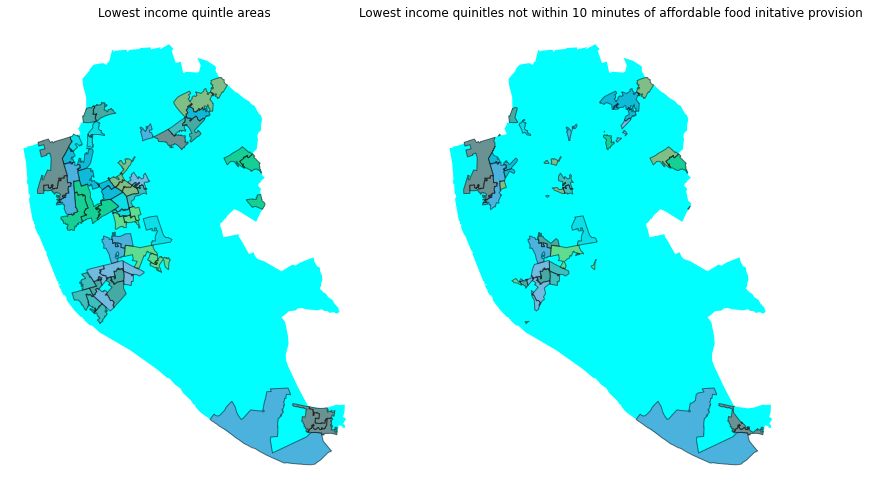

In [222]:
# Plots the lowest income quintile areas and those areas not within 10 minutes of affordable provision side by side

plt.figure(1, figsize=(14,26))
ax1 = plt.subplot(221)
Liverpool_boundary.plot(color='cyan', figsize=(6,13), ax=ax1)
ax1.axis('off') # Turns the axis off
Lower_income.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax1)
plt.title("Lowest income quintle areas")

ax2 = plt.subplot(222)
Liverpool_boundary.plot(color='cyan',figsize=(6,13), ax=ax2)
ax2.axis('off') # Turns off the axis
ax2.set_title("Lowest income quinitles not within 10 minutes of affordable food initative provision")
lower_income_withoutaccess.plot(alpha=0.5, edgecolor='k', cmap='tab10',ax=ax2);

# Create a geojson that for each layer in the map has those that are in the lowest decile and not within 10 minutes

In [237]:
the_variables=['Total population: mid 2015 (excluding prisoners)_rank',
 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)_rank',
 'Population aged 16-59: mid 2015 (excluding prisoners)_rank',
 'Older population aged 60 and over: mid 2015 (excluding prisoners)_rank',
# 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)_rank',
 'Income Domain numerator_rank',
 'Income Deprivation Affecting Children Index (IDACI) numerator_rank',
 'Income Deprivation Affecting Older People Index (IDAOPI) numerator_rank',
 'Employment Domain numerator_rank',
 'Staying on in education post 16 indicator_rank',
 'Entry to higher education indicator_rank',
 'Adult skills and English language proficiency indicator_rank',
 'Years of potential life lost indicator_rank',
 'Comparative illness and disability ratio indicator_rank',
 'Acute morbidity indicator_rank',
 'Mood and anxiety disorders indicator_rank',
 'Road distance to a post office indicator (km)_rank',
 'Road distance to a primary school indicator (km)_rank',
 'Road distance to general store or supermarket indicator (km)_rank',
 'Road distance to a GP surgery indicator (km)_rank',
 'Household overcrowding indicator_rank',
 'Homelessness indicator (rate per 1000 households)_rank',
 'Owner-occupation affordability (component of housing affordability indicator)_rank',
 'Private rental affordability (component of housing affordability indicator)_rank',
 'Housing affordability indicator_rank',
 'Housing in poor condition indicator_rank',
 'Houses without central heating indicator_rank',
 'Road traffic accidents indicator_rank',
 'Nitrogen dioxide (component of air quality indicator)_rank',
 'Benzene (component of air quality indicator)_rank',
 'Sulphur dioxide (component of air quality indicator)_rank',
 'Particulates (component of air quality indicator)_rank',
 'Air quality indicator_rank',
 'Score_rank']

the_variables_short={'population':'Total population: mid 2015 (excluding prisoners)_rank','education':'Staying on in education post 16 indicator_rank',
'crowding':'Household overcrowding indicator_rank','income':'Income Domain numerator_rank','score':'Score_rank','morbidity': 'Acute morbidity indicator_rank'}

population
education
crowding
income
score
morbidity


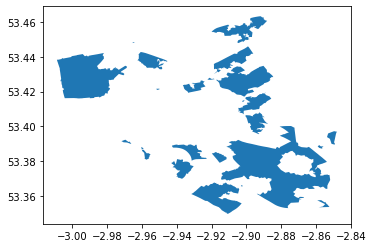

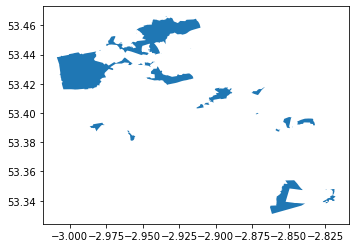

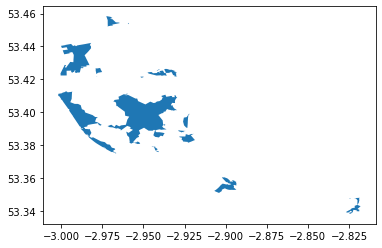

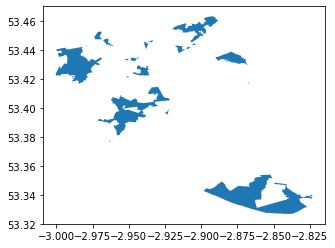

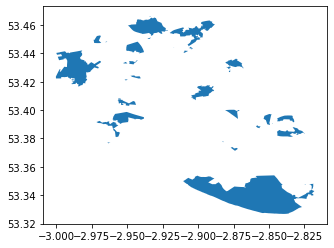

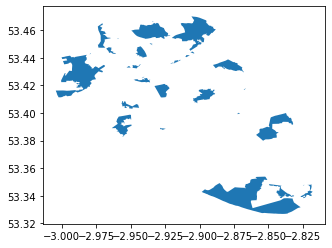

In [238]:
from shapely.ops import orient # version >=1.7a2



def areas_not_close(x):
    not_access=gpd.overlay(x, travel_distances, how='difference')
    # Dissolve the contiguous polygons
    not_access=gpd.geoseries.GeoSeries([geom for geom in not_access.unary_union.geoms]).__geo_interface__
    # Converts to a geopandas dataframe
    not_access = gpd.GeoDataFrame.from_features(not_access)
    # Serts the orientation
    not_access.geometry = not_access.geometry.apply(orient, args=(-1,))
    return not_access

access_layer=[]

# Gets the distance data for the data that is at the lower super output area level
for x in the_variables_short.keys():
         print(x)  
         geom= areas_not_close(Lsoa_multdep[Lsoa_multdep[the_variables_short[x]]==5])
         # Print to check it's producing sensible results
         geom.plot()
         geom.to_file("Data/Out/"+x+".geojson", driver='GeoJSON')
        
 



# Handles the data at the ward level

In [233]:
filename = "Data/Out/Liverpool_wards.geojson"

file = open(filename)
Ward_level_data = gpd.read_file(file)

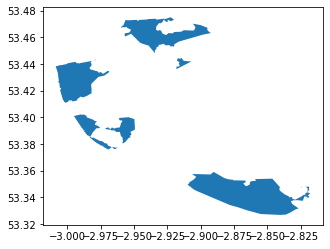

In [236]:
# Add just the ward level obesity data on its own
geom= areas_not_close(Ward_level_data[Ward_level_data['Ward_Reception_Overweight_Obese_rank']==5])
# Print to check it's producing sensible results
geom.plot()
geom.to_file("Data/Out/Obesity.geojson", driver='GeoJSON')
                